# auto-encoderのモデルファイルから画像を生成する

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
from PIL import Image
from StringIO import StringIO
import math

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import six

import matplotlib.pyplot as plt

from model_AE import AE
from model_VAE import VAE

## 入力画像データのロード

In [2]:
# img_size
size = 96
# image path
image_dir = "./images/sports_sample"
# load images
fs = os.listdir(image_dir)
dataset = []
for fn in fs:
    f = open('%s/%s'%(image_dir,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('RGB')).astype(np.float32).transpose(2, 0, 1)
    dataset.append(img)
    f.close()
dataset = np.asarray(dataset)
print("num_of_images : %s"%dataset.shape[0])

## 画素が（-1~1）の範囲に収まるように調整する関数の定義
def clip_img(x):
    return np.float32(-1 if x<(-1) else (1 if x>1 else x))

def draw_img_rgb(data):
    size = 96
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    data /= data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        tmp = data[idx,:,:,:].transpose(1,2,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

N = dataset.shape[0]
train_rate = 0.7
N_train = int(N*train_rate)
N_test = N - N_train
print('N_dataset={}, N_train={}, N_test={}'.format(N, N_train, N_test))

# 正規化(0~1に)
dataset /= 255
# 訓練データとテストデータに分割
x_train, x_test = np.split(dataset,   [N_train])
print x_train.shape
## 訓練データとテストデータは決定論的に分割（単純に最初から７割をくんれんデータにして、残りをテストデータ）

num_of_images : 10000
N_dataset=10000, N_train=7000, N_test=3000
(7000, 3, 96, 96)


## パラメータの設定

In [3]:
model_file = "out/out_models_ae_sp03/model_AE_00100.h5"
size = 96
batchsize = 100 # ミニバッチのサイズ
n_latent = 10000   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
conv_size = 512  # convolution層の最大チャネルサイズ

model = AE(input_size=size, n_latent=n_latent, output_ch=conv_size)
serializers.load_hdf5(model_file, model)


## 画像生成
* CPUだけで描画するようにちょっと変更

[6966  568   36 6846  754 3382 3241 5251   55  820]
input image


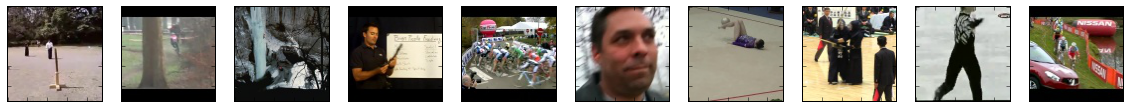

reconstruction image


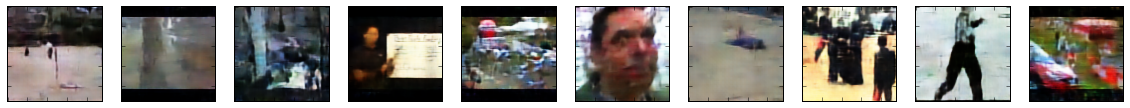

In [4]:
## 描画 Closed test
test_ind = np.random.permutation(N_train)[:10]
print test_ind
test = chainer.Variable(np.asarray(x_train[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_rgb(x_train[test_ind])

print "reconstruction image"
draw_img_rgb(y.data)

[1396 1083 2013  109 2424 2219 2157 2252 1367  535]
input image


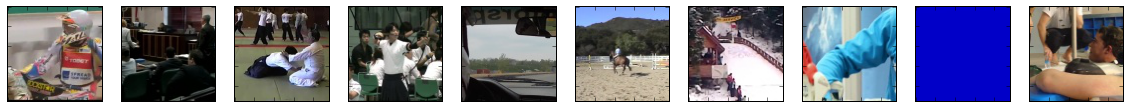

reconstruction image


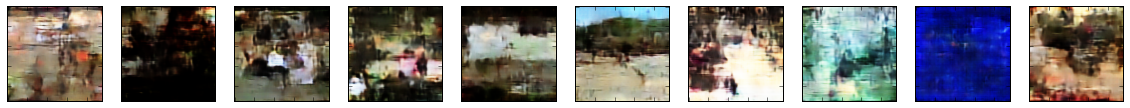

In [5]:
## 描画テスト (Open test) 
test_ind = np.random.permutation(N_test)[:10]
print test_ind
test = chainer.Variable(np.asarray(x_test[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_rgb(x_test[test_ind])

print "reconstruction image"
draw_img_rgb(y.data)

[1, 4, 6, 8, 42, 70, 76, 79, 153, 156]
input image


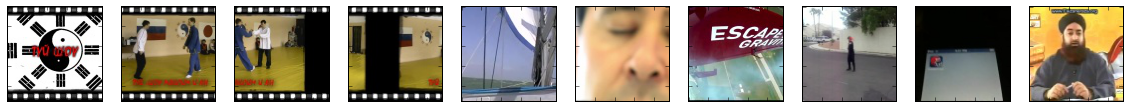

reconstruction image


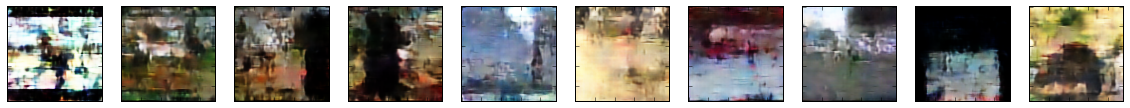

In [6]:
## 描画テスト (Open test, 固定画像) 
#test_ind = np.arange(70,80)
test_ind = [1, 4, 6, 8, 42, 70, 76, 79, 153, 156]
print test_ind
test = chainer.Variable(np.asarray(x_test[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_rgb(x_test[test_ind])

print "reconstruction image"
draw_img_rgb(y.data)

decode image from random vector


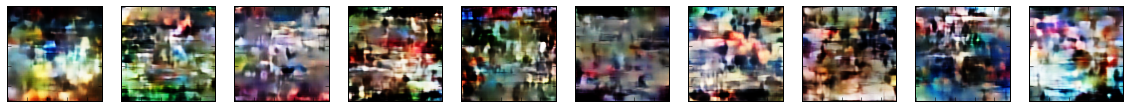

In [7]:
# draw images from randomly sampled z
z = chainer.Variable(np.random.normal(0, 1, (10, n_latent)).astype(np.float32))
x = model.decode(z)
print "decode image from random vector"
draw_img_rgb(x.data)

## ログファイルから、lossの変化をplot